In [54]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
df = pd.read_csv(r'rhc.csv')

In [11]:
df.head()

,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,chfhx,dementhx,psychhx,chrpulhx,renalhx,liverhx,gibledhx,malighx,immunhx,transhx,amihx,age,sex,edu,surv2md1,das2d3pc,t3d30,dth30,aps1,scoma1,meanbp1,wblc1,hrt1,resp1,temp1,pafi1,alb1,hema1,bili1,crea1,sod1,pot1,paco21,ph1,swang1,wtkilo1,dnr1,ninsclas,resp,card,neuro,gastr,renal,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,NaN,Yes,11142,11151.0,NaN,11382,No,0,0,0,0,1,0,0,0,1,0,0,0,70.25098,Male,12.000000,0.640991,23.50000,30,No,46,0,41.0,22.097656,124,10.0,38.69531,68.00000,3.500000,58.000000,1.009766,1.199951,145,4.000000,40.0,7.359375,No RHC,64.69995,No,Medicare,Yes,Yes,No,No,No,No,No,No,No,No,0.0,NaN,white,Under $11k,5
1,2,MOSF w/Sepsis,NaN,No,11799,11844.0,11844.0,11844,Yes,1,1,0,0,0,0,0,0,0,1,1,0,78.17896,Female,12.000000,0.755000,14.75195,30,No,50,0,63.0,28.898438,137,38.0,38.89844,218.31250,2.599609,32.500000,0.699951,0.599976,137,3.299805,34.0,7.329102,RHC,45.69998,No,Private & Medicare,No,No,No,No,No,No,No,Yes,No,No,NaN,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,NaN,12400,No,0,0,0,0,0,0,0,0,1,1,0,0,46.09198,Female,14.069916,0.317000,18.13672,30,No,82,0,57.0,0.049995,130,40.0,36.39844,275.50000,3.500000,21.097656,1.009766,2.599609,146,2.899902,16.0,7.359375,RHC,0.00000,No,Private,No,Yes,No,No,No,No,No,No,No,No,NaN,599.0,white,$25-$50k,9
3,4,ARF,NaN,No,11146,11183.0,11183.0,11182,Yes,0,0,0,0,0,0,0,0,0,1,0,0,75.33197,Female,9.000000,0.440979,22.92969,30,No,48,0,55.0,23.296875,58,26.0,35.79688,156.65625,3.500000,26.296875,0.399963,1.699951,117,5.799805,30.0,7.459961,No RHC,54.59998,No,Private & Medicare,Yes,No,No,No,No,No,No,No,No,No,NaN,NaN,white,$11-$25k,10
4,5,MOSF w/Sepsis,NaN,No,12035,12037.0,12037.0,12036,Yes,0,0,0,0,0,0,0,0,0,0,0,0,67.90997,Male,9.945259,0.437000,21.05078,2,Yes,72,41,65.0,29.699219,125,27.0,34.79688,478.00000,3.500000,24.000000,1.009766,3.599609,126,5.799805,17.0,7.229492,RHC,78.39996,Yes,Medicare,No,Yes,No,No,No,No,No,No,No,No,NaN,64.0,white,Under $11k,11


In [12]:
df = df.replace(to_replace="Yes", value=1)
df = df.replace(to_replace="No", value=0)

In [14]:
df.swang1.value_counts(normalize=True)

No RHC    0.61918
RHC       0.38082
Name: swang1, dtype: float64

In [15]:
df['treated'] = 0

In [16]:
df['treated'] = df['treated'].where(df.swang1=="No RHC", 1)

In [22]:
df['treated'] = np.where(df.swang1 == 'RHC', 1, 0)

In [23]:
df.groupby(by='treated')['death'].mean()

treated
0    0.629682
1    0.680403
Name: death, dtype: float64

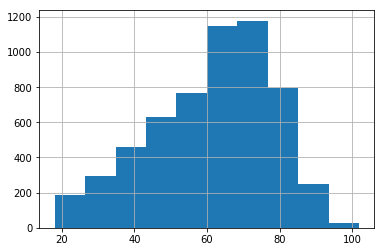

In [33]:
df.age.hist();

In [34]:
pd.cut(df.age, 5).head(5)

0    (68.326, 85.087]
1    (68.326, 85.087]
2    (34.803, 51.564]
3    (68.326, 85.087]
4    (51.564, 68.326]
Name: age, dtype: category
Categories (5, interval[float64]): [(17.958, 34.803] < (34.803, 51.564] < (51.564, 68.326] < (68.326, 85.087] < (85.087, 101.848]]

In [35]:
df['agegrp'] = pd.qcut(df.age,10)

In [37]:
df.groupby('agegrp').size()

agegrp
(18.041, 36.972]     574
(36.972, 46.196]     573
(46.196, 53.386]     574
(53.386, 59.545]     573
(59.545, 64.047]     574
(64.047, 68.068]     573
(68.068, 71.899]     573
(71.899, 76.025]     574
(76.025, 80.883]     573
(80.883, 101.848]    574
dtype: int64

### Logit regression (to compare the results with Propensity matching method)

In [39]:
model = 'death ~ age + sex + edu + treated'

reg_results = smf.logit(formula=model, data=df).fit()
reg_results.summary()

Optimization terminated successfully.
         Current function value: 0.622953
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  death   No. Observations:                 5735
Model:                          Logit   Df Residuals:                     5730
Method:                           MLE   Df Model:                            4
Date:                Fri, 12 Feb 2021   Pseudo R-squ.:                 0.03875
Time:                        23:28:46   Log-Likelihood:                -3572.6
converged:                       True   LL-Null:                       -3716.7
Covariance Type:            nonrobust   LLR p-value:                 4.112e-61
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.2474      0.168     -7.406      0.000      -1.577      -0.917
sex[T.Male]     0.1074      0.057      1.878      0.060      -0.005       0.219
age             0.0277      0.002     15.970      0.000       0.024       0.031
edu             0.0030      0.009      0.327      0.743      -0.015       0.021
treated         0.2526      0.059      4.278      0.000       0.137       0.368
===============================================================================
"""

In [42]:
reg_results.params

Intercept     -1.247385
sex[T.Male]    0.107357
age            0.027699
edu            0.003028
treated        0.252627
dtype: float64

In [40]:
np.exp(reg_results.params)

Intercept      0.287255
sex[T.Male]    1.113332
age            1.028086
edu            1.003032
treated        1.287403
dtype: float64

In [43]:
# np.exp?

In [44]:
df.edu.describe()

count    5735.000000
mean       11.678461
std         3.145831
min         0.000000
25%        10.000000
50%        12.000000
75%        13.000000
max        30.000000
Name: edu, dtype: float64

### Estimate propensity score

In [45]:
df.sex = df.sex.replace('Male', 0)
df.sex = df.sex.replace('Female', 1)

In [46]:
df['male'] = np.where(df.sex == 0, 1, 0)

In [47]:
model = 'treated ~ age + male +edu'
propensity = smf.logit(formula=model, data = df).fit()
propensity.summary()

Optimization terminated successfully.
         Current function value: 0.662209
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                treated   No. Observations:                 5735
Model:                          Logit   Df Residuals:                     5731
Method:                           MLE   Df Model:                            3
Date:                Fri, 12 Feb 2021   Pseudo R-squ.:                0.003394
Time:                        23:52:31   Log-Likelihood:                -3797.8
converged:                       True   LL-Null:                       -3810.7
Covariance Type:            nonrobust   LLR p-value:                 1.017e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7441      0.160     -4.645      0.000      -1.058      -0.430
age           -0.0027      0.002     -1.648      0.099      -0.006       0.001
male           0.1858      0.055      3.374      0.001       0.078       0.294
edu            0.0273      0.009      3.111      0.002       0.010       0.045
==============================================================================
"""

### Check overlap

In [48]:
df.groupby('treated').size()

treated
0    3551
1    2184
dtype: int64

In [49]:
df.groupby('treated').male.mean()

treated
0    0.539003
1    0.585165
Name: male, dtype: float64

In [50]:
df['propensity'] = propensity.predict()

In [52]:
df['propensity'][0:10]

0    0.396208
1    0.347837
2    0.381078
3    0.331200
4    0.384368
5    0.318814
6    0.419408
7    0.413605
8    0.391037
9    0.360308
Name: propensity, dtype: float64

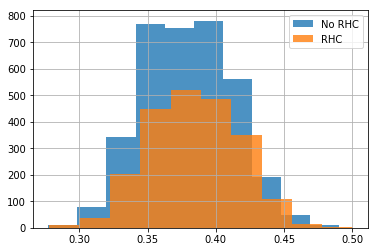

In [55]:
df.groupby('treated')['propensity'].hist(alpha=0.8) 
plt.legend(['No RHC','RHC'])

In [56]:
df.groupby('treated')['propensity'].mean()

treated
0    0.379108
1    0.383603
Name: propensity, dtype: float64

In [57]:
 # Are the treated different in terms of age, sex and edu?

    df.groupby('treated')['age', 'male', 'edu'].mean()

,age,male,edu
treated,,,
0,61.760926,0.539003,11.569005
1,60.749836,0.585165,11.856428
